In [ ]:
# Importing the Necessary Libraries 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from google.colab import drive
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Connecting to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the Weights of the CNN Model with FC Layers 
network = load_model('/content/drive/MyDrive/ChestVGG_SGD.h5')

In [ ]:
# Checking the Layer We Want to Use (Flattening Layer)
network.layers[41].output

<KerasTensor: shape=(None, 50176) dtype=float32 (created by layer 'flatten')>

In [ ]:
# Loading the CNN Model with Layer 41 (Flattening Layer) 
model = Model(inputs=network.input, outputs=network.layers[41].output)

In [ ]:
# Defining the Training and Test Path
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

In [ ]:
# The Settings for Generating the Test Set  
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
# Generating the Test Set 
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=1,
                                            class_mode = 'categorical')

Found 1170 images belonging to 2 classes.


In [ ]:
# Loading the Saved Features Obtained in the Training Process
features_train=np.load('/content/drive/MyDrive/Features_Flattened.npy')

In [ ]:
# Getting the Outputs of Layer 41 (Flattening Layer) as the Input of Machine Learning (ML) Classifiers for Test
features_test=model.predict(test_set, steps=1170, verbose=1)

In [ ]:
# Creating the Hybrid CNN Model with FC Layers
model_fc=Model(inputs=network.layers[41].output, outputs=network.output)

In [ ]:
# Creating Linear Support Vector Machine (SVM) Classifier
from sklearn import svm
svc_linear = svm.SVC(C=1, kernel='linear', max_iter=6000, probability=True)
model_svc_linear=svc_linear.fit(features_train, train_set.classes)

In [ ]:
# Creating Radial Basis Function (RBF) SVM Classifier
svc_rbf = svm.SVC(C=1, kernel='rbf', max_iter=6000, probability=True)
model_svc_rbf=svc_rbf.fit(features_train, train_set.classes)

In [ ]:
# Creating Polynomial SVM Classifier
svc_pol = svm.SVC(C=1, kernel='poly', max_iter=6000, probability=True)
model_svc_pol=svc_pol.fit(features_train, train_set.classes)

In [ ]:
# Creating Logistic Regression (LR) Classifier
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression(max_iter=6000)
model_lr=logit.fit(features_train, train_set.classes)

In [ ]:
# Creating Gaussian Naive Bayes (NB) Classifier
from sklearn.naive_bayes import GaussianNB
classifier_nb=GaussianNB(priors=[0.5, 0.5])
model_nb=classifier_nb.fit(features_train, train_set.classes)

In [ ]:
# Classifying Using All the Classifiers 
models = [model_svc_linear, model_svc_rbf, model_svc_pol, model_lr, model_nb]
preds_1 = [model.predict_proba(features_test) for model in models]
preds_fc=model_fc.predict(features_test)
preds_1.insert(0, preds_fc)
preds_1=np.array(preds_1)

In [ ]:
# Creating the Ensemble Model and Finding the Optimal Weights
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 10):
    for w2 in range(0,10):
        for w3 in range(0,10):
          for w4 in range(0,10):
            for w5 in range(0,10):
              for w6 in range(0,10):
                wts = [w1/10.,w2/10.,w3/10., w4/10.0, w5/10.0, w6/10.0]
                wted_preds1 = np.tensordot(preds_1, wts, axes=((0),(0)))
                wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
                weighted_accuracy = accuracy_score(test_set.classes, wted_ensemble_pred)
                df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                              'wt3':wts[2], 'wt4':wts[3], 'wt5':wts[4], 'wt6':wts[5], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[6], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " w3=", max_acc_row[2], " w4=", max_acc_row[3], " w5=", max_acc_row[4], " and w6=", max_acc_row[5])    

Max accuracy of  98.54700854700855  obained with w1= 0.0  w2= 0.0  w3= 0.4  w4= 0.0  w5= 0.1  and w6= 0.0


In [ ]:
# Classifying Using the Ensemble Classifier According to the Obtained Weights and 
models = [model_svc_linear, model_svc_rbf, model_svc_pol, model_lr, model_nb]
preds = [model.predict_proba(features_test) for model in models]
preds_fc=model_fc.predict(features_test)
preds.insert(0, preds_fc)
preds=np.array(preds_1)
ideal_weights = [max_acc_row[0], max_acc_row[1], max_acc_row[2], max_acc_row[3], max_acc_row[4], max_acc_row[5]] 
#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(test_set.classes, ideal_weighted_ensemble_prediction)

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

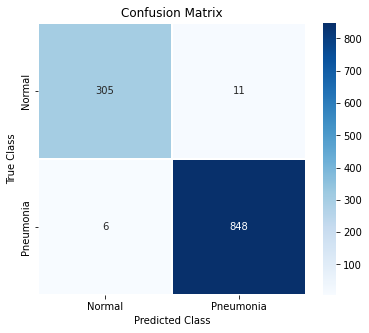

In [ ]:
# Creating the Confusion Matrix 
cf_matrix=confusion_matrix(test_set.classes, ideal_weighted_ensemble_prediction)
ax=plt.figure(figsize=(6,5))
ax=plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])

In [ ]:
Pkl_svc_linear= "/content/drive/MyDrive/svc_linear.pkl"  
with open(Pkl_svc_linear, 'wb') as file:  
    pickle.dump(model_svc_linear, file)

In [ ]:
Pkl_svc_rbf= "/content/drive/MyDrive/svc_rbf.pkl"  
with open(Pkl_svc_rbf, 'wb') as file:  
    pickle.dump(model_svc_rbf, file)

In [ ]:
Pkl_svc_pol= "/content/drive/MyDrive/svc_pol.pkl"  
with open(Pkl_svc_pol, 'wb') as file:  
    pickle.dump(model_svc_pol, file)

In [ ]:
Pkl_lr= "/content/drive/MyDrive/lr.pkl"  
with open(Pkl_lr, 'wb') as file:  
    pickle.dump(model_lr, file)

In [ ]:
Pkl_nb= "/content/drive/MyDrive/nb.pkl"  
with open(Pkl_nb, 'wb') as file:  
    pickle.dump(model_nb, file)

In [ ]:
# Saving the KNN Classifier (The Model with the Highest Test Accuracy (98.55%))
Pkl_knn = "/content/drive/MyDrive/KNN.pkl"  
with open(Pkl_knn, 'wb') as file:  
    pickle.dump(knn_optimized, file)